# Adversarial Examples for MNIST

In this notebook, we create some adversarial samples from the MNIST dataset using the Fast Gradient Sign Method (FSGM) and show how they affect the performance of several neural network models. In order to demonstrate that 

Flow:
1. Divide training data into $X_a$ and $X_b$.
2. Train classifier A on $X_a$.
3. Demonstrate how FGSM confuses classifier A.
4. Train classifier B on $X_a$ with adversarial training data constructed using classifier A. 
5. Train classifier C on $X_a$ with autoencoder layer to first 'denoise' adversarial training data constructed using classifier A.
6. Train classifier D on $X_a$ with output gradient smoothing.
7. Train classifier E with output suppression.
8. Train classifier F with superimposed training samples.
9. Train classifier ...
10. Train classifier Z.
11. Show performance of classifiers A-F... on adversarial MNIST test dataset constructed using classifier Z with a range of $\epsilon$ strengths.
12. Comments/Observations to highlight:
    - Adversarial samples constructed using classifier Z should still work well to confuse classifier A. This demonstrates the generalization of adversarial examples. 
    - Curious to see which classifier does the best.

### Train a Classifier:

In order to create adversarial examples using the FGSM, we need a trained classifier to provide a gradient signal for the FGSM algorithm. The `train.py` script can be run to train a Convolutional Neural Network (CNN) classifier on the MNIST trainin data as follows:

`$ python train.py`

Hyperparameter defaults, such as learnign rate, batch size, and file locations can be reassigned using the optional arguments.

### Let's First Demonstrate How FGSM Works

### Setup

Import packages, define hyperparameters, initialize the data loaders, initialize the CNN classifier, and load the pre-trained model paremeters. The CNN was pre-trained for 10 epochs resulting in 99.1% accuracy on the MNIST test dataset.

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# relative imports
from cnn import CNN
from dataloader_utils import make_mnist_dataloaders, raw_pytorch_dataset
from data_utils import graph_inputs_with_predictions, compute_pytorch_model_accuracy

BATCH_SIZE = 32
NUM_WORKERS = 1
DATA_DIR = '/tmp/mnist_data/'
NUM_CHAN = 1
NUM_CLASS = 10
CLASSIFIER_MODEL_FILE = \
    '/home/dylan/trained_model_files/pytorch/glados/glados_class/glados_class.pt'

# intialize MNIST dataloaders
train_loader, test_loader = make_mnist_dataloaders(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    data_dir=DATA_DIR
)

# initialize classifier
classifier = CNN(
    in_chan=NUM_CHAN,
    out_dim=NUM_CLASS,
    out_act=None
)

# load trained cnn classifier paremeters
classifier.load_state_dict(torch.load(CLASSIFIER_MODEL_FILE, map_location=torch.device('cpu')))

<All keys matched successfully>

### Grab a Small Batch of Samples From the Testing Set Dataloader

We start by grabbing 4 samples from a batch of the MNIST testing set so we can observe how predictions on these samples change as we turn them into adversarial samples. In order to calculate how to alter these samples to make them adversarial, we need to tell Pytorch to record gradient information for them when we compute any gradients by setting the `requires_grad == True` flag in the code block below. 

In [2]:
# get a batch from the test loader and keep only first 4 samples
test_batch = iter(test_loader).next()
test_samples, test_labels = test_batch[0][:4], test_batch[1][:4]

# require gradient for input data (need to do this to compute the gradients for inputs dutring backward() call)
test_samples.requires_grad = True

### Let's Make These Samples Adversarial

Now, we alter the 4 samples above in a way that confuses the CNN classifier into predicting them incorrectly. To do this, we slightly change every pixel within each sample such that the loss at the output of the classifier increases. If we view each sample as a point belonging in high-dimensional pixel space, the slight bump we make by changing the sample actually moves it to a new point in this pixel space. The high-dimensional direction from the original point (original sample) to this new point (altered sample) is actually just the gradient of the classifier loss function with respect to all of these pixel values. 

In [3]:
# compute model outputs on test batch
outputs = classifier(test_samples)

# compute loss on current test batch
loss = torch.nn.functional.cross_entropy(outputs, test_labels)

# compute gradients of loss on backward pass
loss.backward()

# get gradients of input data
grads = test_samples.grad

# perturb test samples using FGSM
adv_test_samples = test_samples + ((0.3) * torch.sign(grads))

# keep pixel vals within [-1, 1]
new_min, new_max = -1., 1.
old_min, old_max = torch.min(adv_test_samples), torch.max(adv_test_samples)
adv_test_samples = (((adv_test_samples - old_min) / (old_max - old_min)) * (new_max - new_min)) + new_min

### Compute Predictions on Regular Test Samples

We run the MNIST test batch through the CNN classifier to get class probability predictions for each sample. We can see from the resulting plots that the classifier has very accurate and confident output precitions for each sample. 

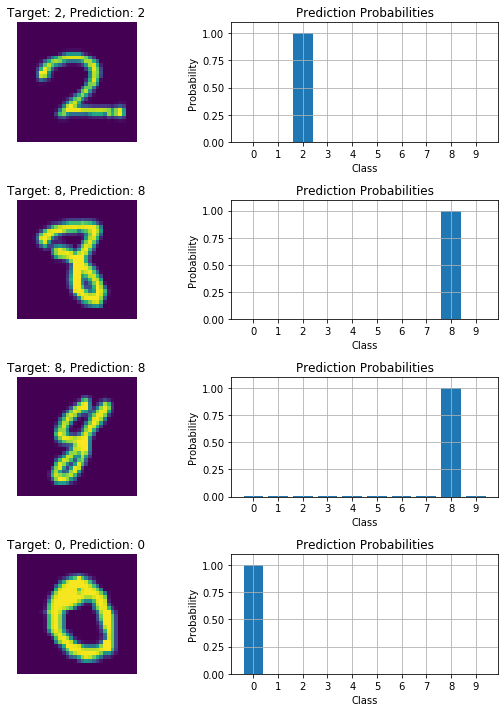

In [4]:
# get predictions
outputs = classifier(test_samples)
pred_prob = torch.nn.functional.softmax(outputs, dim=-1)
pred = torch.argmax(pred_prob, dim=-1)

# convert samples, labels, and prediction probabilities to numpy arrays
samples_np = np.transpose(test_samples.detach().numpy(), [0, 2, 3, 1])
labels_np = test_labels.detach().numpy()
pred_prob_np = pred_prob.detach().numpy()
pred_np = pred.detach().numpy()

# plot the input samples with the corresponding class prediction probabilities
fig = graph_inputs_with_predictions(
    samples_np, 
    labels_np, 
    pred_prob_np, 
    pred_np, 
    figsize=(8, 10)
)

### Compute Predictions on Adversarial Test Samples

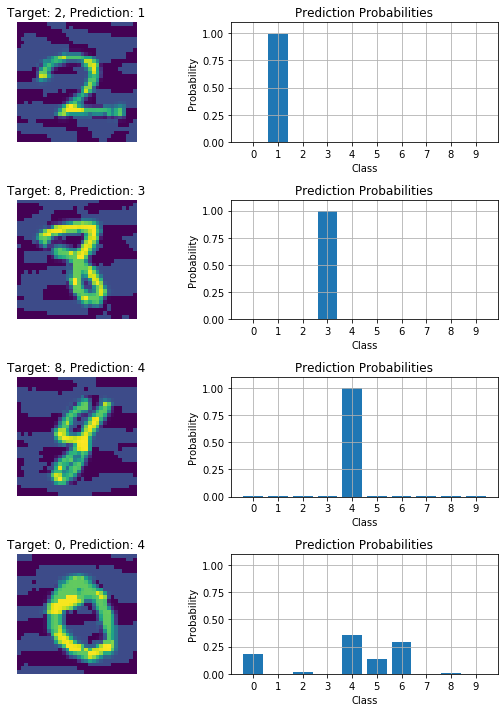

In [5]:
# get predictions on adversarial examples
adv_outputs = classifier(adv_test_samples)
adv_pred_prob = torch.nn.functional.softmax(adv_outputs, dim=-1)
adv_pred = torch.argmax(adv_pred_prob, dim=-1)

# convert samples, labels, and prediction probabilities to numpy arrays
adv_samples_np = np.transpose(adv_test_samples.detach().numpy(), [0, 2, 3, 1])
adv_labels_np = test_labels.detach().numpy()
adv_pred_prob_np = adv_pred_prob.detach().numpy()
adv_pred_np = adv_pred.detach().numpy()

# plot the input samples with the corresponding class prediction probabilities
adv_fig = graph_inputs_with_predictions(
    adv_samples_np, 
    adv_labels_np,
    adv_pred_prob_np, 
    adv_pred_np, 
    figsize=(8, 10)
)

### Train Defense Models

Explain other models.

1. Control model.
2. Adversarially augmented trainign data.
3. Superimposed augmented (mixed) model.
4. Activation suppressed model.

Run:

`$ python train.py`

`$ python train_adversarial.py`

`$ python train_mixed.py`

`$ python train_suppressed.py`

In [6]:
CTRL_CLASSIFIER_MODEL_FILE = \
    '/home/dylan/trained_model_files/pytorch/glados/wheatley_class/wheatley_class.pt'
ADV_CLASSIFIER_MODEL_FILE = \
    '/home/dylan/trained_model_files/pytorch/glados/glados_adv_class/glados_adv_class.pt'
SUPP_CLASSIFIER_MODEL_FILE = \
    '/home/dylan/trained_model_files/pytorch/glados/glados_supp_class/glados_supp_class.pt'
MIX_CLASSIFIER_MODEL_FILE = \
    '/home/dylan/trained_model_files/pytorch/glados/glados_mixed_class/glados_mixed_class.pt'

# initialize control classifier
ctrl_classifier = CNN(
    in_chan=NUM_CHAN,
    out_dim=NUM_CLASS,
    out_act=None
)

# initialize adversarial classifier
adv_classifier = CNN(
    in_chan=NUM_CHAN,
    out_dim=NUM_CLASS,
    out_act=None
)

# initialize suppressed classifier
supp_classifier = CNN(
    in_chan=NUM_CHAN,
    out_dim=NUM_CLASS,
    out_act=None
)

# initialize mixed classifier
mix_classifier = CNN(
    in_chan=NUM_CHAN,
    out_dim=NUM_CLASS,
    out_act=None
)

# load control classifier parameters
ctrl_classifier.load_state_dict(torch.load(CTRL_CLASSIFIER_MODEL_FILE, map_location=torch.device('cpu')))

# load adversarial classifier parameters
adv_classifier.load_state_dict(torch.load(ADV_CLASSIFIER_MODEL_FILE, map_location=torch.device('cpu')))

# load suppressed classifier parameters
supp_classifier.load_state_dict(torch.load(SUPP_CLASSIFIER_MODEL_FILE, map_location=torch.device('cpu')))

# load mixed classifier parameters
mix_classifier.load_state_dict(torch.load(MIX_CLASSIFIER_MODEL_FILE, map_location=torch.device('cpu')))

<All keys matched successfully>

### Sweep Accuracy on Adversarial Test Data for Varying Models and Adversarial Strength

best datastructure for this?

for batch in dataloader:
    for eps in eps_range:
        make adv batch with eps
        for model in models:
            compute model outputs on adv batch
            count num correct for model-eps
            count num total for model-eps
            
for each model-eps pair:
    sum num correct
    sum num total
    compute accuracy for model-eps
    
Now have ______| eps | accuracy |
         model | val | val      |

In [11]:
# range of adversarial strengths 
start, stop, step = [0.0, 0.5, 0.02]
eps_range = np.arange(start, stop+step, step)

# make list of models
models = [ctrl_classifier, adv_classifier, supp_classifier, mix_classifier]

# dataframe columns
columns = ['epsilon', 'ctrl_correct', 'ctrl_total', 'adv_correct', 'adv_total', 
          'supp_correct', 'supp_total', 'mix_correct', 'mix_total']

# create dataframe for this data
df = pd.DataFrame(columns=columns).set_index('epsilon')

print(df)

# iterate through batches
for batch in test_loader:
    # parse batch
    test_samples = batch[0]
    test_labels = batch[1]

    # iterate through epsilon values
    for eps in eps_range:
        # compute model outputs on test batch
        outputs = classifier(test_samples)

        # compute loss on current test batch
        loss = torch.nn.functional.cross_entropy(outputs, test_labels)

        # compute gradients of loss on backward pass
        loss.backward()

        # get gradients of input data
        grads = test_samples.grad

        # perturb test samples using FGSM
        adv_test_samples = test_samples + ((0.3) * torch.sign(grads))

        # keep pixel vals within [-1, 1]
        new_min, new_max = -1., 1.
        old_min, old_max = torch.min(adv_test_samples), torch.max(adv_test_samples)
        adv_test_samples = (((adv_test_samples - old_min) / (old_max - old_min)) * (new_max - new_min)) + new_min
        
        # iterate through trained models
        for model in models:
            # compute predictions on adversarial data
            pred = torch.argmax(model(sample_batch), dim=1)

            # count where predicted == labels and add to correct count
            correct += torch.sum((pred == test_labels)).item()

            # add this batch size to total count
            total += sample_batch.shape[0]
    break

Empty DataFrame
Columns: [ctrl_correct, ctrl_total, adv_correct, adv_total, supp_correct, supp_total, mix_correct, mix_total]
Index: []
torch.Size([32, 1, 32, 32])
torch.Size([32])


### Compute Test Accuracy on All Adversarial Datasets

In [8]:
# get accuracy for each adversarial dataset on each model
#test_acc_list = [compute_pytorch_model_accuracy(classifier, v) for k, v in adv_test_datasets.items()]
#supp_test_acc_list = [compute_pytorch_model_accuracy(supp_classifier, v) for k, v in adv_test_datasets.items()]

# define graph layout
#layout = go.Layout(
#    title='Test Accuracy as Adversarial Perturbation Strength Increases',
#    xaxis_title='Epsilon',
#    yaxis_title='Test Accuracy (%)'
#)

# add all line plots to data list
#data = [
#    go.Scatter(x=list(adv_test_datasets.keys()), y=test_acc_list, name='classifier'),
#    go.Scatter(x=list(adv_test_datasets.keys()), y=supp_test_acc_list, name='suppressed_classifier')
#]

# construct line graph
#fig = go.Figure(data=data, layout=layout)

#fig.show()